# Transformation of CP to renta media

We use data from https://www.agenciatributaria.es/AEAT/Contenidos_Comunes/La_Agencia_Tributaria/Estadisticas/Publicaciones/sites/irpfCodPostal/2018/jrubik611aa8cadac183b7602d273c915147ecedbd7c2a.html that contains data of the renta media disponible per CP

Renta bruta y Renta disponible inframunicipal (2018)
Tramos de Base Imponible: Total

** El valor de renta disponible en matadepera es el del 2017 ya que en 2018 pasó de 41.789 a 166.006 y infliuria en el analisis.

In [29]:
import pandas as pd
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings("ignore")

In [30]:
renta_media = pd.read_excel('../data/raw/renta_cp.xlsx')
final_merge = pd.read_csv('../data/raw/final_merge.csv')

In [31]:
final_merge.shape

(11426, 46)

In [32]:
def remove_accents(text):
    return unidecode(text)

In [33]:
def transform_column_names(df):
    df.columns = map(remove_accents,df.columns)
    df.columns = [col.replace(' ', '_').lower() for col in df.columns]
    return df

In [34]:
renta_media.columns = [remove_accents(col) for col in renta_media.columns]

In [35]:
renta_media = transform_column_names(renta_media)

In [36]:
renta_media.shape

(701, 4)

In [37]:
renta_media.columns

Index(['region', 'numero_de_declaraciones', 'renta_bruta_media',
       'renta_disponible_media'],
      dtype='object')

In [38]:
#First we want to extract the CPs of the "Código postal" column. We will use regex.

def extract_cp(df):

    data = df['region']
    df['CP'] = None

    for index, address in enumerate(df['region']):  #enumerate() keeps track of index and value
        match = re.search(r'\b\d{5}\b', address)     # Using regex to find a sequence of 5 digits

        if match:
            df.loc[index, 'CP'] = match.group() #group() se utiliza para extraer el match

        else:
            df.loc[index, 'CP'] = None
    return df

In [39]:
renta_media = extract_cp(renta_media)

In [40]:
#from all columns we are interested in codigo_postal and renta_disponible_media
renta_media = renta_media[['CP', 'renta_disponible_media']]

In [41]:
renta_media = renta_media.dropna(subset=['CP']) #The initial dataframe has the row 'Resto' from where we can't extract CP

In [42]:
renta_media.shape

(661, 2)

In [43]:
renta_media.columns

Index(['CP', 'renta_disponible_media'], dtype='object')

In [44]:
renta_media['CP'] = renta_media['CP'].astype(int)

In [45]:
#We want to merge the dfs so we can add the 'renta_disponible_media' to each students row
#We do left join so we don't lose students information
merged_df = pd.merge(final_merge, renta_media, on=['CP'], how='left',indicator=True)

In [46]:
#calculation of the median
merged_df_for_median = merged_df.drop_duplicates(subset=['NIA'])
median = merged_df_for_median['renta_disponible_media'].median()
median

27556.0

In [47]:
#388 students didn't get their renta_disponible_media data --> We will try to fill it with values that make sense
#We will substitute NaNs with the 'renta_disponible_media' of the province they belong
        # starts with'17' --> 22.866 #girona
        # starts with'43' --> 22.067 #tarragona
        # starts with'25' --> 21.307 #lleida
        # starts with '8' --> 26.663 #Barcelona
        # starts with '7' --> 24.114 #Balears
#For the rest values we will use the median value of 'renta_disponible_media' in the existing values

def fill_renta_disponible(row):
    
    if pd.isna(row['renta_disponible_media']):

        if str(row['CP']).startswith('8'):
            return 26663
        
        elif str(row['CP']).startswith('17'):
            return 22866
        
        elif str(row['CP']).startswith('25'):
            return 21307
        
        elif str(row['CP']).startswith('43'):
            return 22067
        
        elif str(row['CP']).startswith('7'):
            return 24114
        
        else:
            return 27556 #median for the values previous to the filling of NaNs
    else:
        return row['renta_disponible_media']


In [48]:
merged_df['renta_disponible_media'] = merged_df.apply(fill_renta_disponible, axis=1)

In [49]:
final_df = merged_df[['CP','renta_disponible_media']]

In [50]:
final_df.isnull().sum()

CP                        0
renta_disponible_media    0
dtype: int64

In [51]:
final_df.shape

(11635, 2)

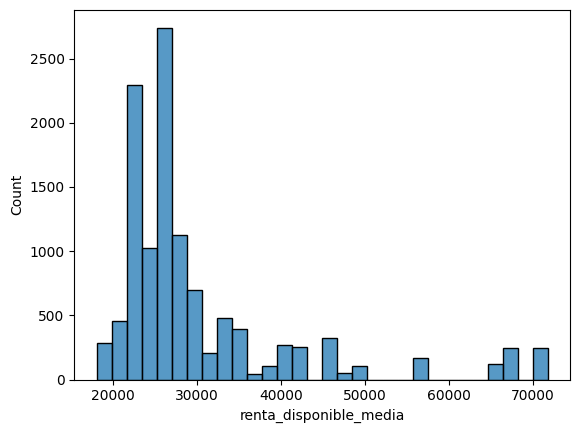

In [52]:
sns.histplot(x=final_df['renta_disponible_media'], bins=30);

In [53]:
#To save the document we want to keep just all the CPs in our dataset with their corresponding renta_disponible_media value.
#We will merge it later to the big dataset 
final_df = final_df.drop_duplicates()

In [54]:
final_df.shape

(328, 2)

In [55]:
#Saving the clean dfs into the clean data folder
final_df.to_csv('../data/processed/renta_disponible.csv', index=False)